In [4]:
!pip install -q tensorflow tensorflow-addons tensorflow-hub tensorflow-datasets
!pip install -q gdown matplotlib seaborn
!pip install keras-facenet

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
import tensorflow_hub as hub
from keras_facenet import FaceNet
import pandas as pd
import numpy as np
import os
from pathlib import Path
import zipfile
import gdown
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, files
import warnings
warnings.filterwarnings('ignore')

In [5]:
drive.mount('/content/drive')
DATASET_PATH = "/content/drive/MyDrive/datasets/FairFace"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

if os.path.exists(DATASET_PATH):
    print("Path exists.")
else:
    print("Path does not exist.")

# Verify dataset structure
expected_files = [
    "train_labels.csv",
    "val_labels.csv",
    "train/",
    "val/"
]

print(f"Loading dataset from: {DATASET_PATH}")

# Check if all required files/folders exist
missing_files = []
for item in expected_files:
    if not os.path.exists(os.path.join(DATASET_PATH, item)):
        missing_files.append(item)

if missing_files:
    raise FileNotFoundError(
        f"Dataset incomplete. Missing: {missing_files}\n"
        f"Expected structure:\n"
        f"{DATASET_PATH}/\n"
        f"├── train_labels.csv\n"
        f"├── val_labels.csv\n"
        f"├── train/ [contains images]\n"
        f"└── val/   [contains images]"
    )


# Set paths for data loading
TRAIN_CSV_PATH = os.path.join(DATASET_PATH, "train_labels.csv")
VAL_CSV_PATH = os.path.join(DATASET_PATH, "val_labels.csv")
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "train")
VAL_IMG_DIR = os.path.join(DATASET_PATH, "val")

print("\nDataset structure verified:")
print(f"Training CSV:   {TRAIN_CSV_PATH}")
print(f"Validation CSV: {VAL_CSV_PATH}")
print(f"Training images: {TRAIN_IMG_DIR} ({len(os.listdir(TRAIN_IMG_DIR))} files)")
print(f"Validation images: {VAL_IMG_DIR} ({len(os.listdir(VAL_IMG_DIR))} files)")

Path exists.
Loading dataset from: /content/drive/MyDrive/datasets/FairFace

Dataset structure verified:
Training CSV:   /content/drive/MyDrive/datasets/FairFace/train_labels.csv
Validation CSV: /content/drive/MyDrive/datasets/FairFace/val_labels.csv
Training images: /content/drive/MyDrive/datasets/FairFace/train (26399 files)
Validation images: /content/drive/MyDrive/datasets/FairFace/val (0 files)


In [7]:
class FairFaceDataProcessor:
    def __init__(self, csv_path, img_dir, img_size=160, sample_size=None, is_validation=False):
        self.img_size = img_size
        self.img_dir = img_dir
        self.is_validation = is_validation

        # Load CSV data
        self.df = pd.read_csv(csv_path)

        # Sample data if specified
        if sample_size and sample_size < len(self.df):
            self.df = self.df.sample(n=sample_size, random_state=42).reset_index(drop=True)
            print(f"Sampled {'validation' if is_validation else 'training'}: {len(self.df)} samples")

        # Initialize label encoders only once (use training data to fit)
        if not hasattr(self, 'age_encoder'):
            self.age_encoder = LabelEncoder()
            self.gender_encoder = LabelEncoder()
            self.race_encoder = LabelEncoder()

            # Fit encoders on this dataset
            self.age_encoder.fit(self.df['age'])
            self.gender_encoder.fit(self.df['gender'])
            self.race_encoder.fit(self.df['race'])

        # Encode labels
        self.df['age_encoded'] = self.age_encoder.transform(self.df['age'])
        self.df['gender_encoded'] = self.gender_encoder.transform(self.df['gender'])
        self.df['race_encoded'] = self.race_encoder.transform(self.df['race'])

        self.num_classes = {
            'age': len(self.age_encoder.classes_),
            'gender': len(self.gender_encoder.classes_),
            'race': len(self.race_encoder.classes_)
        }

        print(f"Classes - Age: {self.num_classes['age']}, Gender: {self.num_classes['gender']}, Race: {self.num_classes['race']}")
        if not is_validation:  # Only print once
            print(f"Age groups: {list(self.age_encoder.classes_)}")
            print(f"Gender groups: {list(self.gender_encoder.classes_)}")
            print(f"Race groups: {list(self.race_encoder.classes_)}")

    def filter_missing_files(self):
        """Filter out rows where image files don't exist"""
        print(f"Original dataset size: {len(self.df)}")

        # Check which files exist
        existing_files = []
        for idx, row in self.df.iterrows():
            img_path = os.path.join(self.img_dir, row['file'])
            if os.path.exists(img_path):
                existing_files.append(idx)

        # Filter dataframe to keep only existing files
        self.df = self.df.loc[existing_files].reset_index(drop=True)

        print(f"Filtered dataset size: {len(self.df)} (removed {len(existing_files)} missing files)")

        return self

    def load_and_preprocess_image(self, image_path, augment=False):
        """Load and preprocess single image"""
        try:
            # Check if file exists
            if not tf.io.gfile.exists(image_path):
                print(f"Warning: File not found: {image_path}")
                return tf.zeros([self.img_size, self.img_size, 3], dtype=tf.float32)

            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, [self.img_size, self.img_size])
            image = tf.cast(image, tf.float32) / 255.0

            if augment:
                # Data augmentation
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_brightness(image, 0.1)
                image = tf.image.random_contrast(image, 0.9, 1.1)
                image = tf.image.random_saturation(image, 0.9, 1.1)
                image = tf.image.random_hue(image, 0.05)

            # Normalize using ImageNet statistics (for FaceNet compatibility)
            image = tf.image.per_image_standardization(image)
            return image
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return black image if file not found
            return tf.zeros([self.img_size, self.img_size, 3], dtype=tf.float32)

    def create_dataset(self, batch_size=32, augment=False, shuffle=True):
        """Create TensorFlow dataset"""
        def generator():
            indices = np.arange(len(self.df))
            if shuffle:
                np.random.shuffle(indices)

            for idx in indices:
                row = self.df.iloc[idx]

                img_path = os.path.join(self.img_dir, row['file'])

                # Debug: Print first few paths to verify
                # if idx < 3:
                #     print(f"Loading image from: {img_path}")
                #     print(f"File exists: {os.path.exists(img_path)}")

                image = self.load_and_preprocess_image(img_path, augment)

                yield (
                    image,
                    {
                        'age_output': tf.cast(row['age_encoded'], dtype=tf.int32),
                        'gender_output': tf.cast(row['gender_encoded'], dtype=tf.int32),
                        'race_output': tf.cast(row['race_encoded'], dtype=tf.int32)
                    }
                )

        # Create dataset
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.img_size, self.img_size, 3), dtype=tf.float32),
                {
                    'age_output': tf.TensorSpec(shape=(), dtype=tf.int32),
                    'gender_output': tf.TensorSpec(shape=(), dtype=tf.int32),
                    'race_output': tf.TensorSpec(shape=(), dtype=tf.int32)
                }
            )
        )

        if shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [8]:
class FaceNetMultiTask(tf.keras.Model):
    def __init__(self, num_age_classes, num_gender_classes, num_race_classes,
                 freeze_backbone=False):
        super(FaceNetMultiTask, self).__init__()

        #  Load FaceNet backbone
        # self.facenet = FaceNet()
        # self.facenet_model = self.facenet.model

        # # Remove the final layer to get embeddings
        # self.backbone = Model(
        #     inputs=self.facenet_model.input,
        #     outputs=self.facenet_model.layers[-2].output  # Get embeddings before final layer
        # )

        self.backbone = FaceNet().model

        # Freeze backbone if specified
        if freeze_backbone:
            self.backbone.trainable = False

        # Classification heads
        self.age_classifier = tf.keras.Sequential([
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(num_age_classes, activation='softmax', name='age_output')
        ], name='age_head') # Add name to sequential model

        self.gender_classifier = tf.keras.Sequential([
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(num_gender_classes, activation='softmax', name='gender_output')
        ], name='gender_head') # Add name to sequential model

        self.race_classifier = tf.keras.Sequential([
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(num_race_classes, activation='softmax', name='race_output')
        ], name='race_head') # Add name to sequential model


    def call(self, inputs, training=None):
        # Get FaceNet embeddings
        embeddings = self.backbone(inputs, training=training)

        # Multi-task predictions
        age_pred = self.age_classifier(embeddings, training=training)
        gender_pred = self.gender_classifier(embeddings, training=training)
        race_pred = self.race_classifier(embeddings, training=training)

        return {
            'age_output': age_pred, # Changed key to match data generator and compile
            'gender_output': gender_pred, # Changed key to match data generator and compile
            'race_output': race_pred # Changed key to match data generator and compile
        }

def create_and_compile_model(num_age_classes, num_gender_classes, num_race_classes, freeze_backbone=True):
    """Create and compile the multi-task model with proper loss functions"""

    model = FaceNetMultiTask(
        num_age_classes=num_age_classes,
        num_gender_classes=num_gender_classes,
        num_race_classes=num_race_classes,
        freeze_backbone=freeze_backbone
    )

    # Build the model
    model.build((None, 160, 160, 3))

    # Optimizer with learning rate schedule
    initial_lr = 0.001
    optimizer = optimizers.AdamW(learning_rate=initial_lr, weight_decay=1e-4)

    # FIXED: Use SparseCategoricalCrossentropy for each output
    # This works with integer labels (no need for one-hot encoding)
    model.compile(
        optimizer=optimizer,
        loss={
            'age_output': losses.SparseCategoricalCrossentropy(),
            'gender_output': losses.SparseCategoricalCrossentropy(),
            'race_output': losses.SparseCategoricalCrossentropy()
        },
        loss_weights={
            'age_output': 1.0,
            'gender_output': 1.0,
            'race_output': 1.0
        },
        metrics={
            'age_output': ['sparse_categorical_accuracy'],
            'gender_output': ['sparse_categorical_accuracy'],
            'race_output': ['sparse_categorical_accuracy']
        }
    )

    return model

In [9]:
BATCH_SIZE = 32
IMG_SIZE = 160
EPOCHS = 20
SAMPLE_SIZE = 5000  # Reduced sample size to avoid memory issues

print("Creating training data processor...")
train_processor = FairFaceDataProcessor(
    TRAIN_CSV_PATH,
    DATASET_PATH,
    img_size=IMG_SIZE,
    sample_size=SAMPLE_SIZE,
    is_validation=False
).filter_missing_files()

print("\nCreating validation data processor...")
val_processor = FairFaceDataProcessor(
    VAL_CSV_PATH,
    DATASET_PATH,
    img_size=IMG_SIZE,
    sample_size=SAMPLE_SIZE//5 if SAMPLE_SIZE else None,
    is_validation=True
).filter_missing_files()

# Copy encoders from training to validation processor
val_processor.age_encoder = train_processor.age_encoder
val_processor.gender_encoder = train_processor.gender_encoder
val_processor.race_encoder = train_processor.race_encoder

# Re-encode validation labels with training encoders
val_processor.df['age_encoded'] = val_processor.age_encoder.transform(val_processor.df['age'])
val_processor.df['gender_encoded'] = val_processor.gender_encoder.transform(val_processor.df['gender'])
val_processor.df['race_encoded'] = val_processor.race_encoder.transform(val_processor.df['race'])

print("\nCreating datasets...")
train_dataset = train_processor.create_dataset(
    batch_size=BATCH_SIZE,
    augment=True,
    shuffle=True
)

val_dataset = val_processor.create_dataset(
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False
)


Creating training data processor...
Sampled training: 5000 samples
Classes - Age: 9, Gender: 2, Race: 7
Age groups: ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
Gender groups: ['Female', 'Male']
Race groups: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
Original dataset size: 5000
Filtered dataset size: 1568 (removed 1568 missing files)

Creating validation data processor...
Sampled validation: 1000 samples
Classes - Age: 9, Gender: 2, Race: 7
Original dataset size: 1000
Filtered dataset size: 0 (removed 0 missing files)

Creating datasets...


In [10]:
print("Building model...")
model = create_and_compile_model(
    num_age_classes=train_processor.num_classes['age'],
    num_gender_classes=train_processor.num_classes['gender'],
    num_race_classes=train_processor.num_classes['race'],
    freeze_backbone=True  # Freeze FaceNet weights initially
)

print(model.summary())

Building model...


Model: "face_net_multi_task"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v1             │ (None, 512)            │    23,497,424 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_head (Sequential)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender_head (Sequential)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ race_head (Sequential)          │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,497,424 (89.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,497,424 (89.64 MB)

None


In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        '/content/best_fairface_facenet_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]



In [12]:
def verify_dataset_structure():
    print("=== Dataset Structure Verification ===")

    # Check CSV files
    train_csv = pd.read_csv(TRAIN_CSV_PATH)
    val_csv = pd.read_csv(VAL_CSV_PATH)

    print(f"Training CSV shape: {train_csv.shape}")
    print(f"Validation CSV shape: {val_csv.shape}")
    print(f"Training CSV columns: {list(train_csv.columns)}")

    # Check image directories
    train_images = os.listdir(TRAIN_IMG_DIR)
    val_images = os.listdir(VAL_IMG_DIR) if os.path.exists(VAL_IMG_DIR) else []

    print(f"Training images found: {len(train_images)}")
    print(f"Validation images found: {len(val_images)}")

    # Check if CSV files match image files
    print("\n=== File Matching Check ===")

    # Sample a few files from CSV and check if they exist
    sample_files = train_csv['file'].head(10).tolist()
    missing_files = []

    for file_name in sample_files:
        # full_path = os.path.join(TRAIN_IMG_DIR, file_name)
        full_path = os.path.join(DATASET_PATH, file_name)
        if not os.path.exists(full_path):
            missing_files.append(full_path)
        else:
            print(f"✓ Found: {full_path}")

    if missing_files:
        print(f"✗ Missing files: {missing_files}")
    else:
        print("✓ All sampled files found!")

    # Check first few rows of CSV
    print(f"\nFirst few rows of training CSV:")
    print(train_csv.head())

    return len(missing_files) == 0

# Run verification
dataset_ok = verify_dataset_structure()

if dataset_ok:
    print("\n✓ Dataset structure looks good! Proceeding with training...")
else:
    print("\n✗ Dataset structure issues found. Please check file paths.")

=== Dataset Structure Verification ===
Training CSV shape: (86744, 5)
Validation CSV shape: (10954, 5)
Training CSV columns: ['file', 'age', 'gender', 'race', 'service_test']
Training images found: 26399
Validation images found: 0

=== File Matching Check ===
✓ Found: /content/drive/MyDrive/datasets/FairFace/train/1.jpg
✓ Found: /content/drive/MyDrive/datasets/FairFace/train/2.jpg
✓ Found: /content/drive/MyDrive/datasets/FairFace/train/3.jpg
✓ Found: /content/drive/MyDrive/datasets/FairFace/train/4.jpg
✓ Found: /content/drive/MyDrive/datasets/FairFace/train/5.jpg
✓ Found: /content/drive/MyDrive/datasets/FairFace/train/6.jpg
✓ Found: /content/drive/MyDrive/datasets/FairFace/train/7.jpg
✓ Found: /content/drive/MyDrive/datasets/FairFace/train/8.jpg
✓ Found: /content/drive/MyDrive/datasets/FairFace/train/9.jpg
✓ Found: /content/drive/MyDrive/datasets/FairFace/train/10.jpg
✓ All sampled files found!

First few rows of training CSV:
          file    age  gender        race  service_test
0  

In [13]:
print("Starting training...")
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Starting training...
Epoch 1/10
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/21584.jpg
File exists: True
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/32130.jpg
File exists: True
     13/Unknown 861s 19s/step - age_output_loss: 2.7076 - age_output_sparse_categorical_accuracy: 0.1349 - gender_output_loss: 0.8115 - gender_output_sparse_categorical_accuracy: 0.6206 - loss: 5.7492 - race_output_loss: 2.2302 - race_output_sparse_categorical_accuracy: 0.2201Loading image from: /content/drive/MyDrive/datasets/FairFace/train/28074.jpg
File exists: True
     48/Unknown 954s 7s/step - age_output_loss: 2.4438 - age_output_sparse_categorical_accuracy: 0.2007 - gender_output_loss: 0.6808 - gender_output_sparse_categorical_accuracy: 0.6967 - loss: 5.0295 - race_output_loss: 1.9049 - race_output_sparse_categorical_accuracy: 0.3343

49/49 ━━━━━━━━━━━━━━━━━━━━ 958s 7s/step - age_output_loss: 2.4357 - age_output_sparse_categorical_accuracy: 0.2028 - gender_output_loss: 0.6766 - gender_output_sparse_categorical_accuracy: 0.6988 - loss: 5.0080 - race_output_loss: 1.8957 - race_output_sparse_categorical_accuracy: 0.3377 - learning_rate: 0.0010
Epoch 2/10
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/21584.jpg
File exists: True
 1/49 ━━━━━━━━━━━━━━━━━━━━ 8:53 11s/step - age_output_loss: 1.4435 - age_output_sparse_categorical_accuracy: 0.5000 - gender_output_loss: 0.3565 - gender_output_sparse_categorical_accuracy: 0.8438 - loss: 2.7980 - race_output_loss: 0.9980 - race_output_sparse_categorical_accuracy: 0.5312Loading image from: /content/drive/MyDrive/datasets/FairFace/train/28074.jpg
File exists: True
13/49 ━━━━━━━━━━━━━━━━━━━━ 14s 393ms/step - age_output_loss: 1.6321 - age_output_sparse_categorical_accuracy: 0.4486 - gender_output_loss: 0.4516 - gender_output_sparse_categorical_accuracy: 0.8144 -

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - age_output_loss: 1.7207 - age_output_sparse_categorical_accuracy: 0.4186 - gender_output_loss: 0.4540 - gender_output_sparse_categorical_accuracy: 0.8070 - loss: 3.4659 - race_output_loss: 1.2912 - race_output_sparse_categorical_accuracy: 0.5276 - learning_rate: 0.0010
Epoch 3/10
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/28074.jpg
File exists: True
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/32130.jpg
File exists: True
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/21584.jpg
File exists: True
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - age_output_loss: 1.5475 - age_output_sparse_categorical_accuracy: 0.4294 - gender_output_loss: 0.4359 - gender_output_sparse_categorical_accuracy: 0.8065 - loss: 3.2600 - race_output_loss: 1.2766 - race_output_sparse_categorical_accuracy: 0.5387

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - age_output_loss: 1.5488 - age_output_sparse_categorical_accuracy: 0.4298 - gender_output_loss: 0.4349 - gender_output_sparse_categorical_accuracy: 0.8070 - loss: 3.2593 - race_output_loss: 1.2755 - race_output_sparse_categorical_accuracy: 0.5387 - learning_rate: 0.0010
Epoch 4/10
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/21584.jpg
File exists: True
 1/49 ━━━━━━━━━━━━━━━━━━━━ 9:06 11s/step - age_output_loss: 1.3077 - age_output_sparse_categorical_accuracy: 0.6562 - gender_output_loss: 0.3922 - gender_output_sparse_categorical_accuracy: 0.8438 - loss: 2.8998 - race_output_loss: 1.1999 - race_output_sparse_categorical_accuracy: 0.5312Loading image from: /content/drive/MyDrive/datasets/FairFace/train/28074.jpg
File exists: True
 8/49 ━━━━━━━━━━━━━━━━━━━━ 16s 398ms/step - age_output_loss: 1.3880 - age_output_sparse_categorical_accuracy: 0.5102 - gender_output_loss: 0.4565 - gender_output_sparse_categorical_accuracy: 0.8170

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - age_output_loss: 1.4485 - age_output_sparse_categorical_accuracy: 0.4629 - gender_output_loss: 0.4061 - gender_output_sparse_categorical_accuracy: 0.8290 - loss: 3.0291 - race_output_loss: 1.1745 - race_output_sparse_categorical_accuracy: 0.5657 - learning_rate: 0.0010
Epoch 5/10
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/21584.jpg
File exists: True
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/32130.jpg
File exists: True
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/28074.jpg
File exists: True
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - age_output_loss: 1.4110 - age_output_sparse_categorical_accuracy: 0.4713 - gender_output_loss: 0.3887 - gender_output_sparse_categorical_accuracy: 0.8156 - loss: 2.8905 - race_output_loss: 1.0909 - race_output_sparse_categorical_accuracy: 0.5827

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - age_output_loss: 1.4119 - age_output_sparse_categorical_accuracy: 0.4709 - gender_output_loss: 0.3884 - gender_output_sparse_categorical_accuracy: 0.8159 - loss: 2.8919 - race_output_loss: 1.0915 - race_output_sparse_categorical_accuracy: 0.5825 - learning_rate: 0.0010
Epoch 6/10
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/21584.jpg
File exists: True
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/28074.jpg
File exists: True
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/32130.jpg
File exists: True
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - age_output_loss: 1.3362 - age_output_sparse_categorical_accuracy: 0.4831 - gender_output_loss: 0.3394 - gender_output_sparse_categorical_accuracy: 0.8591 - loss: 2.7386 - race_output_loss: 1.0630 - race_output_sparse_categorical_accuracy: 0.5914

49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - age_output_loss: 1.3365 - age_output_sparse_categorical_accuracy: 0.4830 - gender_output_loss: 0.3396 - gender_output_sparse_categorical_accuracy: 0.8589 - loss: 2.7400 - race_output_loss: 1.0639 - race_output_sparse_categorical_accuracy: 0.5912 - learning_rate: 0.0010
Epoch 7/10
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/21584.jpg
File exists: True
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/28074.jpg
File exists: True
 9/49 ━━━━━━━━━━━━━━━━━━━━ 15s 394ms/step - age_output_loss: 1.2176 - age_output_sparse_categorical_accuracy: 0.5109 - gender_output_loss: 0.3447 - gender_output_sparse_categorical_accuracy: 0.8333 - loss: 2.6267 - race_output_loss: 1.0644 - race_output_sparse_categorical_accuracy: 0.6126Loading image from: /content/drive/MyDrive/datasets/FairFace/train/32130.jpg
File exists: True
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - age_output_loss: 1.2424 - age_output_sparse_categorical_ac

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - age_output_loss: 1.2448 - age_output_sparse_categorical_accuracy: 0.5129 - gender_output_loss: 0.3302 - gender_output_sparse_categorical_accuracy: 0.8483 - loss: 2.6392 - race_output_loss: 1.0641 - race_output_sparse_categorical_accuracy: 0.6062 - learning_rate: 0.0010
Epoch 8/10
 5/49 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - age_output_loss: 1.1902 - age_output_sparse_categorical_accuracy: 0.5530 - gender_output_loss: 0.2578 - gender_output_sparse_categorical_accuracy: 0.8712 - loss: 2.5741 - race_output_loss: 1.1261 - race_output_sparse_categorical_accuracy: 0.5334Loading image from: /content/drive/MyDrive/datasets/FairFace/train/32130.jpg
File exists: True
 6/49 ━━━━━━━━━━━━━━━━━━━━ 16s 390ms/step - age_output_loss: 1.1945 - age_output_sparse_categorical_accuracy: 0.5494 - gender_output_loss: 0.2660 - gender_output_sparse_categorical_accuracy: 0.8701 - loss: 2.5676 - race_output_loss: 1.1072 - race_output_sparse_categorical_accuracy: 0.5461Lo

49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - age_output_loss: 1.2414 - age_output_sparse_categorical_accuracy: 0.5211 - gender_output_loss: 0.3289 - gender_output_sparse_categorical_accuracy: 0.8564 - loss: 2.5927 - race_output_loss: 1.0224 - race_output_sparse_categorical_accuracy: 0.6127 - learning_rate: 0.0010
Epoch 9/10
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/21584.jpg
File exists: True
 4/49 ━━━━━━━━━━━━━━━━━━━━ 17s 396ms/step - age_output_loss: 1.1143 - age_output_sparse_categorical_accuracy: 0.5443 - gender_output_loss: 0.3083 - gender_output_sparse_categorical_accuracy: 0.8418 - loss: 2.3242 - race_output_loss: 0.9016 - race_output_sparse_categorical_accuracy: 0.6322Loading image from: /content/drive/MyDrive/datasets/FairFace/train/28074.jpg
File exists: True
 8/49 ━━━━━━━━━━━━━━━━━━━━ 16s 391ms/step - age_output_loss: 1.1412 - age_output_sparse_categorical_accuracy: 0.5425 - gender_output_loss: 0.3241 - gender_output_sparse_categorical_accuracy: 0.838

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - age_output_loss: 1.1839 - age_output_sparse_categorical_accuracy: 0.5357 - gender_output_loss: 0.3151 - gender_output_sparse_categorical_accuracy: 0.8581 - loss: 2.4869 - race_output_loss: 0.9879 - race_output_sparse_categorical_accuracy: 0.6202 - learning_rate: 0.0010
Epoch 10/10
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/21584.jpg
File exists: True
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/28074.jpg
File exists: True
Loading image from: /content/drive/MyDrive/datasets/FairFace/train/32130.jpg
File exists: True
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - age_output_loss: 1.2047 - age_output_sparse_categorical_accuracy: 0.5169 - gender_output_loss: 0.2729 - gender_output_sparse_categorical_accuracy: 0.8932 - loss: 2.4745 - race_output_loss: 0.9969 - race_output_sparse_categorical_accuracy: 0.6292

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - age_output_loss: 1.2049 - age_output_sparse_categorical_accuracy: 0.5171 - gender_output_loss: 0.2735 - gender_output_sparse_categorical_accuracy: 0.8929 - loss: 2.4768 - race_output_loss: 0.9984 - race_output_sparse_categorical_accuracy: 0.6282 - learning_rate: 0.0010
Training completed!


In [19]:
print("Available history keys:", list(history.history.keys()))

Available history keys: ['age_output_loss', 'age_output_sparse_categorical_accuracy', 'gender_output_loss', 'gender_output_sparse_categorical_accuracy', 'loss', 'race_output_loss', 'race_output_sparse_categorical_accuracy', 'learning_rate']


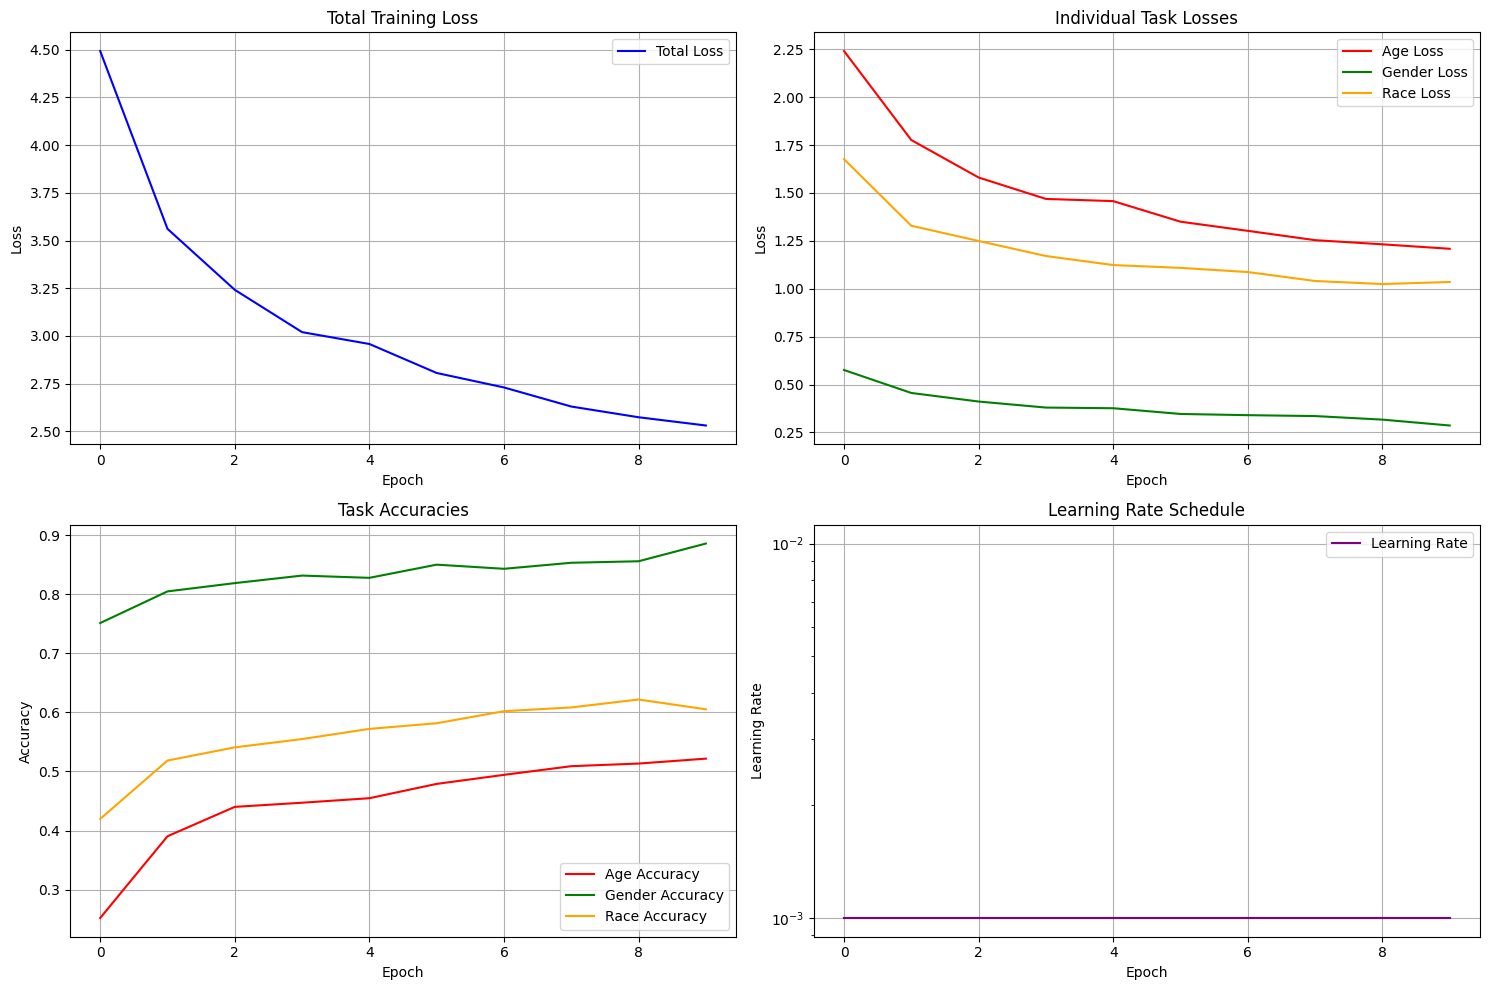

Final Training Metrics:
Total Loss: 2.5306
Age Loss: 1.2087
Gender Loss: 0.2864
Race Loss: 1.0354
Age Accuracy: 0.5217
Gender Accuracy: 0.8858
Race Accuracy: 0.6052
Final Learning Rate: 1.00e-03


In [20]:

def plot_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Total Loss
    ax1.plot(history.history['loss'], label='Total Loss', color='blue')
    ax1.set_title('Total Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Individual Task Losses
    ax2.plot(history.history['age_output_loss'], label='Age Loss', color='red')
    ax2.plot(history.history['gender_output_loss'], label='Gender Loss', color='green')
    ax2.plot(history.history['race_output_loss'], label='Race Loss', color='orange')
    ax2.set_title('Individual Task Losses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # Task Accuracies
    ax3.plot(history.history['age_output_sparse_categorical_accuracy'], label='Age Accuracy', color='red')
    ax3.plot(history.history['gender_output_sparse_categorical_accuracy'], label='Gender Accuracy', color='green')
    ax3.plot(history.history['race_output_sparse_categorical_accuracy'], label='Race Accuracy', color='orange')
    ax3.set_title('Task Accuracies')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True)

    # Learning Rate
    ax4.plot(history.history['learning_rate'], label='Learning Rate', color='purple')
    ax4.set_title('Learning Rate Schedule')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.legend()
    ax4.grid(True)
    ax4.set_yscale('log')  # Log scale for learning rate

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("Final Training Metrics:")
    print(f"Total Loss: {history.history['loss'][-1]:.4f}")
    print(f"Age Loss: {history.history['age_output_loss'][-1]:.4f}")
    print(f"Gender Loss: {history.history['gender_output_loss'][-1]:.4f}")
    print(f"Race Loss: {history.history['race_output_loss'][-1]:.4f}")
    print(f"Age Accuracy: {history.history['age_output_sparse_categorical_accuracy'][-1]:.4f}")
    print(f"Gender Accuracy: {history.history['gender_output_sparse_categorical_accuracy'][-1]:.4f}")
    print(f"Race Accuracy: {history.history['race_output_sparse_categorical_accuracy'][-1]:.4f}")
    print(f"Final Learning Rate: {history.history['learning_rate'][-1]:.2e}")

plot_history(history)


In [22]:
def predict_sample(model, img_path, train_processor, img_size=(160, 160)):
    """
    Predict demographics for a single image
    """
    # Load and preprocess image - matching training preprocessing
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    # Apply same normalization as training (ImageNet standardization)
    img = tf.image.per_image_standardization(img)
    img = tf.expand_dims(img, axis=0)  # Add batch dim

    # Predict
    preds = model.predict(img, verbose=0)

    # Extract predictions - model returns a dictionary
    age_pred = np.argmax(preds['age_output'][0])
    gender_pred = np.argmax(preds['gender_output'][0])
    race_pred = np.argmax(preds['race_output'][0])

    # Decode labels using the training processor encoders
    age_label = train_processor.age_encoder.inverse_transform([age_pred])[0]
    gender_label = train_processor.gender_encoder.inverse_transform([gender_pred])[0]
    race_label = train_processor.race_encoder.inverse_transform([race_pred])[0]

    # Display - load original image for display
    display_img = tf.io.read_file(img_path)
    display_img = tf.image.decode_image(display_img, channels=3)
    display_img = tf.image.resize(display_img, img_size)
    display_img = tf.cast(display_img, tf.float32) / 255.0

    plt.figure(figsize=(8, 6))
    plt.imshow(display_img)
    plt.title(f"Predictions:\nAge: {age_label}\nGender: {gender_label}\nRace: {race_label}")
    plt.axis('off')
    plt.show()

    return age_label, gender_label, race_label

In [23]:
def test_predictions(model, train_processor, num_samples=3):
    """Test predictions on random samples from filtered training data"""

    # Get some sample files from the filtered training data
    sample_indices = np.random.choice(len(train_processor.df), num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        print(f"\n=== Sample {i+1} ===")
        row = train_processor.df.iloc[idx]
        img_path = os.path.join(train_processor.img_dir, row['file'])

        # True labels
        true_age = row['age']
        true_gender = row['gender']
        true_race = row['race']

        print(f"True labels - Age: {true_age}, Gender: {true_gender}, Race: {true_race}")

        # Predict
        pred_age, pred_gender, pred_race = predict_sample(model, img_path, train_processor)

        # Compare
        print(f"Predicted - Age: {pred_age}, Gender: {pred_gender}, Race: {pred_race}")
        print(f"Correct - Age: {true_age == pred_age}, Gender: {true_gender == pred_gender}, Race: {true_race == pred_race}")


=== Sample 1 ===
True labels - Age: 40-49, Gender: Male, Race: Black


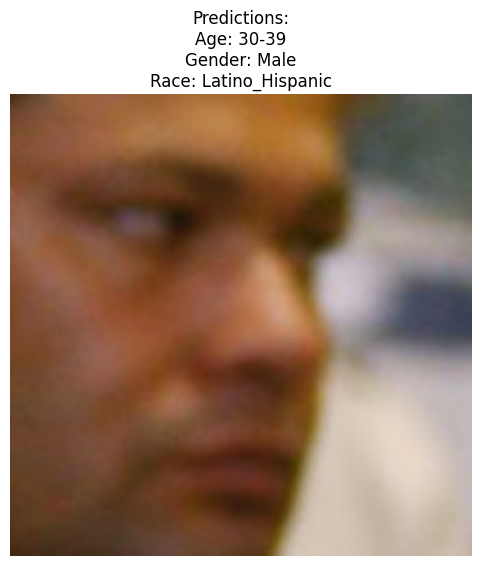

Predicted - Age: 30-39, Gender: Male, Race: Latino_Hispanic
Correct - Age: False, Gender: True, Race: False

=== Sample 2 ===
True labels - Age: 20-29, Gender: Female, Race: Black


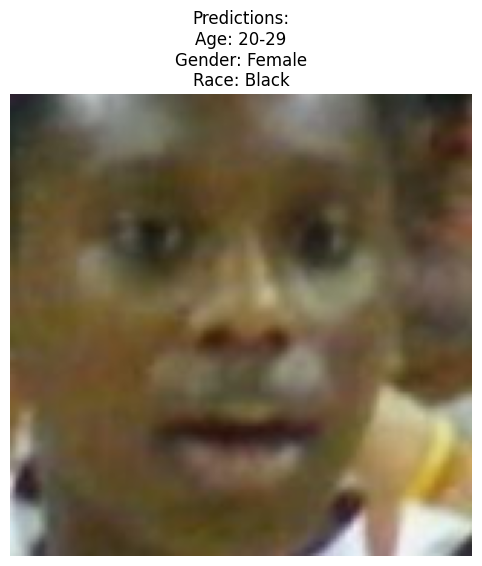

Predicted - Age: 20-29, Gender: Female, Race: Black
Correct - Age: True, Gender: True, Race: True

=== Sample 3 ===
True labels - Age: 10-19, Gender: Male, Race: Middle Eastern


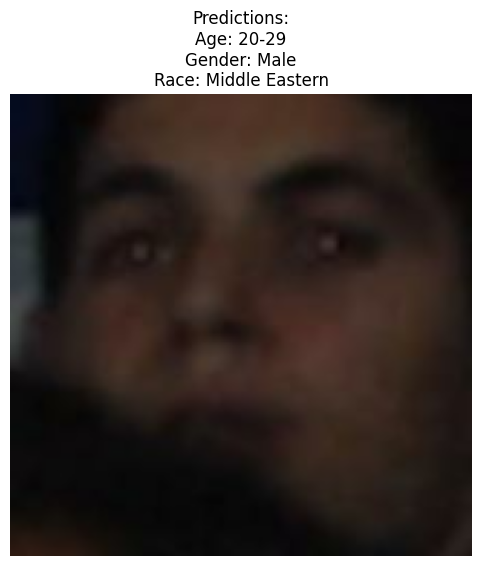

Predicted - Age: 20-29, Gender: Male, Race: Middle Eastern
Correct - Age: False, Gender: True, Race: True

=== Sample 4 ===
True labels - Age: 30-39, Gender: Male, Race: Black


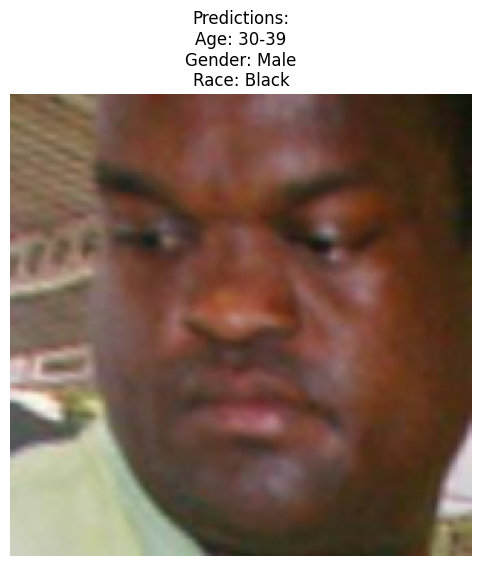

Predicted - Age: 30-39, Gender: Male, Race: Black
Correct - Age: True, Gender: True, Race: True

=== Sample 5 ===
True labels - Age: 3-9, Gender: Male, Race: East Asian


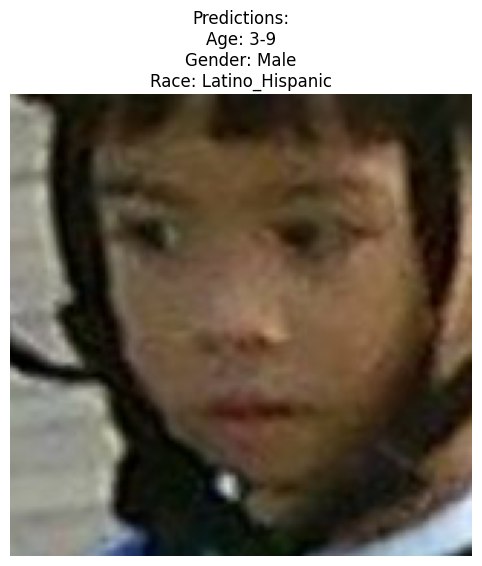

Predicted - Age: 3-9, Gender: Male, Race: Latino_Hispanic
Correct - Age: True, Gender: True, Race: False


In [24]:
test_predictions(model, train_processor, num_samples=5)